# Titanic

## Setup

In [12]:
# general imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for project imports
import sys
from pathlib import Path

root = Path.cwd().parent
sys.path.append(str(root))

## Load Data

In [ ]:
import pandas as pd
from src.kaggle_utils import download_kaggle_competition

files = download_kaggle_competition("titanic")
print(files)

train_df = pd.read_csv(root / Path("data/raw/titanic/train.csv"))
test_df  = pd.read_csv(root / Path("data/raw/titanic/test.csv"))

X = train_df.drop(columns=["Survived", "Name", "Ticket", "Cabin"])
y = train_df["Survived"]

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head()

[PosixPath('data/raw/titanic/test.csv'), PosixPath('data/raw/titanic/train.csv'), PosixPath('data/raw/titanic/gender_submission.csv')]


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,TotalFamily,SingleTraveler,LargeFamily,AgeGroup,FareCategory,Deck,HasCabin
331,332,1,male,45.5,0,0,28.5000,C124,S,1,1,0,Adult,High,C,1
733,734,2,male,23.0,0,0,13.0000,NaN,S,1,1,0,Young,Medium,NaN,0
382,383,3,male,32.0,0,0,7.9250,NaN,S,1,1,0,Adult,Low,NaN,0
704,705,3,male,26.0,1,0,7.8542,NaN,S,2,0,0,Young,Low,NaN,0
813,814,3,female,6.0,4,2,31.2750,NaN,S,7,0,1,Child,Premium,NaN,0


## Train Model

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

numeric_features = ["Age", "SibSp", "Parch", "Fare"]
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_features = ["Pclass", "Sex", "Embarked"]
categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__penalty": ["l2"],
    "classifier__solver": ["lbfgs"]
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)


Best parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Validation Accuracy: 0.7988826815642458


## Train Random Forest

Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 150}
Validation Accuracy: 0.8268156424581006


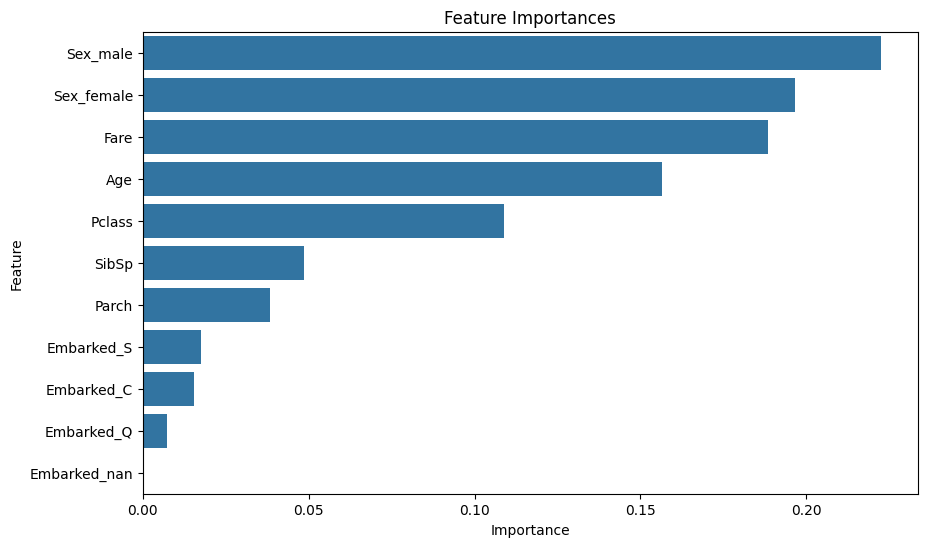

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from src.transformers import GroupedImputer

numeric_features = ["Age", "SibSp", "Parch", "Fare", "Pclass"]

numeric_transformer = Pipeline(steps=[
    ('imputer', GroupedImputer(target_col='Age', group_cols=['Pclass', 'SibSp'], strategy='median')),
])

categorical_features = ["Sex", "Embarked"]

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, max_features='sqrt'))
])

param_grid = {
    'classifier__n_estimators': [120, 150, 170],
    'classifier__max_depth': [8, 10, 12],
    'classifier__min_samples_split': [8, 10, 12]
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

# examine feature importances
feature_names = (numeric_features +
                 list(grid_search.best_estimator_.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .get_feature_names_out(categorical_features)))
importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False) 
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()  


## XGBoost

In [45]:
import xgboost as xgb

numeric_features = ["Age", "SibSp", "Parch", "Fare", "Pclass"]

numeric_transformer = Pipeline(steps=[
    ('imputer', GroupedImputer(target_col='Age', group_cols=['Pclass', 'SibSp'], strategy='median')),
])

categorical_features = ["Sex", "Embarked"]

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(eval_metric='mlogloss'))
])

# tune hyperparameters if needed
param_grid = {
    'classifier__n_estimators': [20, 50, 100, 120],
    'classifier__max_depth': [2, 3, 4],
    'classifier__learning_rate': [0.05, 0.1, 0.15]
}
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Refit best model
best_model = grid_search.best_estimator_
best_model.fit(X, y)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Predict

In [49]:
# prdict on test set
X_test = test_df.drop(columns=["Name", "Ticket", "Cabin"])
y_test_pred = best_model.predict(X_test)
submission_df = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": y_test_pred
})
submission_df.to_csv(root / Path("data/processed/titanic_submission.csv"), index=False)